In [1]:
import pandas as pd
import numpy as np
import time
import re
import seaborn as sns
from matplotlib import pyplot as plt
import tensorflow as tf


from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

from nltk.corpus import stopwords
import nltk


#nltk.download('wordnet')
#nltk.download('omw-1.4')

#import spacy
#from nltk.corpus import stopwords

In [2]:

data=pd.read_csv("C:/Users/ranus/OneDrive/Bureau/DataScience/ClassificationMessageTwitter/ClassificationMessageTwitter/Corona_NLP_train.csv",parse_dates=True ,encoding='latin-1')
data

data_test=pd.read_csv("C:/Users/ranus/OneDrive/Bureau/DataScience/ClassificationMessageTwitter/ClassificationMessageTwitter/Corona_NLP_test.csv",parse_dates=True ,encoding='latin-1')
data_test.shape
data["OriginalTweet"][0]

'@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8'

#  Data analysis

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


Les variables sont de types int et et object.
On remarque également des données manquantes dans la colonne Location.

In [4]:
is_int=list(data.select_dtypes("int64").columns)
for col in is_int:
    print(data[col].value_counts())

3799     1
31291    1
31233    1
31234    1
31235    1
        ..
17519    1
17520    1
17521    1
17522    1
44955    1
Name: UserName, Length: 41157, dtype: int64
48751    1
76243    1
76185    1
76186    1
76187    1
        ..
62471    1
62472    1
62473    1
62474    1
89907    1
Name: ScreenName, Length: 41157, dtype: int64


On remarque ScreenName et UserName sont des clefs de la dataframe. On peut donc en drop une et utiliser l'autre comme index

In [5]:
data=data.set_index("UserName")
#data=data.drop("ScreenName",axis=1)
data

,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
UserName,,,,,
3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...,...,...,...
44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral
44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative
44953,89905,NaN,14-04-2020,You know itÂs getting tough when @KameronWild...,Positive


# Etude des données manquantes

In [6]:
data[data["Location"].isna()]


,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
UserName,,,,,
3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
3813,48765,NaN,16-03-2020,ADARA Releases COVID-19 Resource Center for Tr...,Positive
3821,48773,NaN,16-03-2020,We have AMAZING CHEAP DEALS! FOR THE #COVID201...,Extremely Positive
3822,48774,NaN,16-03-2020,We have AMAZING CHEAP DEALS! FOR THE #COVID201...,Extremely Positive
...,...,...,...,...,...
44947,89899,NaN,14-04-2020,UV light Sterilizer Sanitizer for your mask an...,Extremely Positive
44950,89902,NaN,14-04-2020,@MrSilverScott you are definitely my man. I fe...,Extremely Positive
44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative


La disposition des données manquantes semble aléatoire.

In [7]:
data.fillna("U",inplace=True)


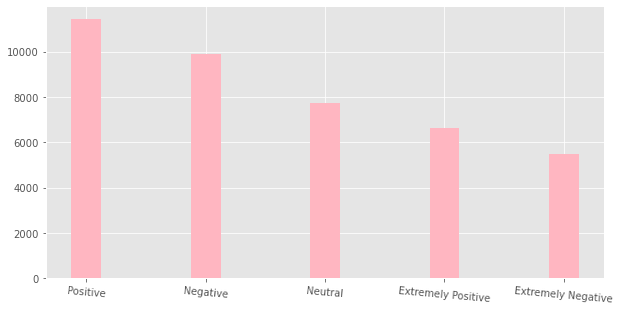

In [8]:
c=data["Sentiment"].value_counts()
plt.style.use('ggplot')
plt.figure(figsize=(10,5))
plt.bar(x=c.index,height=c.values,width=0.25,color="lightpink")
plt.xticks(rotation=-5)
plt.show()

Il n'y a pas de désequilibre majeur entre les classes.

# Impact du temps sur les classes

In [9]:
###### 
data_time=data.copy()
data_time["TweetAt"]=pd.to_datetime(data["TweetAt"],format='%d-%m-%Y')
#changement d'index
data_time=data_time.set_index("TweetAt")
#data_time
#plt.figure()
data_time["ScreenName"].resample("M").agg(sum)

TweetAt
2020-03-31    1568188500
2020-04-30    1285185153
Freq: M, Name: ScreenName, dtype: int64

C:\Users\ranus\anaconda3\envs\Tensorflow\lib\site-packages\pandas\core\indexes\base.py:6393: UserWarning: Parsing '31-03-2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  label = self._maybe_cast_slice_bound(label, side)


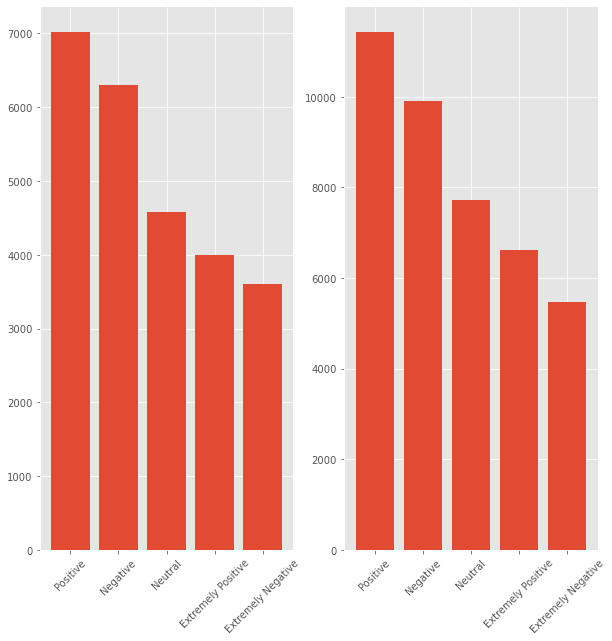

In [10]:
df1=pd.DataFrame(data_time["Sentiment"][:"31-03-2020"].value_counts())
df1["Emotion"]=df1.index
df1=df1.set_index(pd.Index([i for i in range(df1.shape[0])]))
df2=pd.DataFrame(data_time["Sentiment"]["01-04-2020":].value_counts())
df2["Emotion"]=df2.index
df2=df2.set_index(pd.Index([i for i in range(df2.shape[0])]))
#df2
#df2.drop(5,axis=0)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.bar(df1["Emotion"],df1["Sentiment"])
plt.xticks(rotation=45)
plt.subplot(1,2,2)
plt.bar(df2["Emotion"],df2["Sentiment"])
plt.xticks(rotation=45)

plt.show()

Le mois de publication des tweet ne semble pas avoir d'impact sur les sentiments.

In [11]:
#sw_nltk=stopwords.words('english')

In [12]:
target=data["Sentiment"]
data=data.drop("Sentiment",axis=1)
data


,ScreenName,Location,TweetAt,OriginalTweet
UserName,,,,
3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...
3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...
3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...
3802,48754,U,16-03-2020,My food stock is not the only one which is emp...
3803,48755,U,16-03-2020,"Me, ready to go at supermarket during the #COV..."
...,...,...,...,...
44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...
44952,89904,U,14-04-2020,Response to complaint not provided citing COVI...
44953,89905,U,14-04-2020,You know itÂs getting tough when @KameronWild...


In [13]:

#encodage de la variable cible
encoder=LabelEncoder()
target=pd.DataFrame(encoder.fit_transform(target))



In [14]:
t=time.time()
def traitement1(char):
    char = re.sub("'", "", char) # to avoid removing contractions in english
    char = re.sub("@[A-Za-z0-9_]+","", char)
    char = re.sub("#[A-Za-z0-9_]+","", char)
    char = re.sub(r'http\S+', '', char)
    char = re.sub('[()!?]', ' ', char)
    char = re.sub('\[.*?\]',' ', char)
    char = re.sub("[^a-z0-9]"," ", char)
    return char
def traitement2(liste):
    n=len(liste)
    
    #on definie un liste avec des caractère et des ponctuation
    car=["@","#",".","?","!","...",":"]
    l=[]
    for i in range(n):
        liste[i]=liste[i].lower()
   
    #On retire les éléments présent dans la liste car
    l=[word for word in liste if word not in car]
    
    #filtration des stop words
    liste1=list(filter(lambda word: word not in stopwords.words("english"),l))
    
    #stemmatisation
    #stemmer=nltk.stem.SnowballStemmer('english')
    #liste2=[stemmer.stem(word) for word in liste1]
    
    #lemmatisation
    lemmatizer=nltk.stem.WordNetLemmatizer()
    liste3=[lemmatizer.lemmatize(word) for word in liste1]
    
    return liste3
        


#nltk.download('punkt')
#n=data.shape[0]
#for i in range(n):
#   token=nltk.word_tokenize(data.iloc[i,2])
data["OriginalTweet"]=data['OriginalTweet'].apply(traitement1)
#data
data["OriginalTweet"]=data['OriginalTweet'].apply(nltk.word_tokenize)
#data
# convertie les majuscule en minuscule
data["OriginalTweet"]=data["OriginalTweet"].apply(traitement2)
time.time()-t




216.53320050239563

In [15]:
data

,ScreenName,Location,TweetAt,OriginalTweet
UserName,,,,
3799,48751,London,16-03-2020,[]
3800,48752,UK,16-03-2020,"[advice, alk, neighbour, family, exchange, pho..."
3801,48753,Vagabonds,16-03-2020,"[oronavirus, ustralia, oolworths, give, elderl..."
3802,48754,U,16-03-2020,"[food, stock, one, empty, dont, panic, take, n..."
3803,48755,U,16-03-2020,"[e, ready, go, supermarket, outbreak, ot, para..."
...,...,...,...,...
44951,89903,"Wellington City, New Zealand",14-04-2020,"[irline, pilot, offering, stock, supermarket, ..."
44952,89904,U,14-04-2020,"[esponse, complaint, provided, citing, 19, rel..."
44953,89905,U,14-04-2020,"[ou, know, getting, tough, rationing, toilet, ..."


Nous devons désormais encoder Location et OriginalTweet. Comme les categories des deux variables n'ont pas plus de poids nous utiliserons un encodage du type OneHotEncoder.

In [16]:
#cat = keras.utils.to_categorical()

In [19]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
#enc=tf.keras.utils.to_categorical
#ohe=OneHotEncoder()
#count_v=CountVectorizer()
#t=pd.DataFrame({"token":[["Je",'Mange'],["des","gateaux","chocolat"]]})
#n=t.shape[0]
#liste_mots=[]
#for i in range(n):
 #   liste_num=[]
  #  for word in t["token"][i]:
   #     if word not in liste_mots:
    #        liste_mots.append(word)
     #       liste_num.append(liste_mots.index(word))
      #  elif word in liste_mots:
       #     liste_num.append(liste_mots.index(word))
        #t["token"][i]=liste_num
#tf.keras.utils.to_categorical(t)     
            

In [24]:
##### from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
df=pd.DataFrame(mlb.fit_transform(data["OriginalTweet"])) # donne une dataframe de dimension 41152 x 33720
acp=PCA()
result=acp.fit_transform(df)
col_name=['PC' +str(j) for j in range(result.shape[1])]
result2=pd.DataFrame(result,columns=col_name)
result2


#l=[[1,2,3],[1,4,5]]
#for i in range(len(l)):
 #   print(pd.get_dummies(l[i]))

ValueError: Too large work array required -- computation cannot be performed with standard 32-bit LAPACK.

Nous allons choisir les composante principaux à garder en fonction de la variance qu'elles expliquent. Nous allons fxer le seuil à 80%

In [ ]:
evr=[np.cumsum(acp.explained_variance_ratio_)>0.8].value_counts()


In [ ]:
data.drop("OriginalTweet",axis=1)
data=data.merge(data,df,axis=1)
data

In [ ]:
data_train,data_test,target_train,target_test=train_test_split(data,target,test_size=0.2)


In [ ]:
param_grid={"max_depth":[2,3],"min_samples_leaf":[1,2,3]}
cv = KFold(n_splits=3)
rf=RandomForestClassifier()